# Determinized Precover with Rho-Arc Factoring

This notebook visualizes the determinized precover DFA for several FSTs and target strings,
comparing the **standard** DFA (from `LazyDeterminize`) against the **rho-factored** DFA
(from `SymbolicLazyDeterminize`).  The rho-factored DFA is exact (same language), but uses
a single **ρ** (rho) arc to represent the most common destination, dramatically reducing
the number of arcs.

In [1]:
from transduction import examples, EPSILON
from transduction.fst import FST
from transduction.fsa import FSA
from transduction.lazy import LazyDeterminize
from transduction.precover_nfa import PrecoverNFA
from transduction.symbolic_precover import RHO, SymbolicLazyDeterminize, ExpandRho
from transduction.viz import display_table, visualize_automaton
from IPython.display import display, Markdown

In [2]:
def fmt_rho_edge(i, a, j):
    """Format edge labels, rendering the RHO sentinel as ρ."""
    if a is RHO:
        return 'ρ'
    if a == EPSILON:
        return 'ε'
    return str(a)


def show_precover(fst, target, title=None):
    """Display FST, standard precover DFA, and rho-factored precover DFA side-by-side."""
    target = tuple(target)
    alphabet = fst.A - {EPSILON}

    # Standard DFA
    std_dfa = LazyDeterminize(PrecoverNFA(fst, target)).materialize()
    std_arcs = sum(1 for s in std_dfa.states for _ in std_dfa.arcs(s))

    # Rho-factored DFA
    sym_lazy = SymbolicLazyDeterminize(PrecoverNFA(fst, target), alphabet)
    rho_dfa = sym_lazy.materialize()
    rho_arcs = sum(1 for s in rho_dfa.states for _ in rho_dfa.arcs(s))
    n_rho = sum(1 for s in rho_dfa.states for a, _ in rho_dfa.arcs(s) if a is RHO)

    # Verify equality
    expanded = ExpandRho(sym_lazy, alphabet).materialize()
    eq = std_dfa.min().equal(expanded.min())

    target_str = repr(target) if not all(isinstance(t, str) for t in target) else repr(''.join(target))
    label = title or ''
    display(Markdown(
        f"### {label}target = {target_str}\n\n"
        f"Standard: **{len(std_dfa.states)}** states, **{std_arcs}** arcs &nbsp;|&nbsp; "
        f"Rho-factored: **{len(rho_dfa.states)}** states, **{rho_arcs}** arcs "
        f"({n_rho} ρ) &nbsp;|&nbsp; "
        f"Equal: {'✓' if eq else '✗'}"
    ))

    display_table(
        [[
            std_dfa.graphviz(),
            rho_dfa.graphviz(fmt_edge=fmt_rho_edge),
        ]],
        headings=[f'Standard DFA ({std_arcs} arcs)', f'Rho DFA ({rho_arcs} arcs)'],
    )

## 1. Simple replacement FST

A single-state FST that replaces each input symbol with a different output symbol.
At the boundary (target fully matched), the DFA has arcs for every input symbol,
all going to the same destination — a perfect case for ρ-arc compression.

In [3]:
fst_replace = examples.replace([
    ('1', 'a'), ('2', 'b'), ('3', 'c'), ('4', 'd'), ('5', 'e'),
])

show_precover(fst_replace, ('a',), title='Replace FST, ')
show_precover(fst_replace, ('a', 'b'), title='Replace FST, ')

### Replace FST, target = 'a'

Standard: **2** states, **6** arcs &nbsp;|&nbsp; Rho-factored: **2** states, **2** arcs (1 ρ) &nbsp;|&nbsp; Equal: ✓

Standard DFA (6 arcs),Rho DFA (2 arcs)
"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- start_{(0, ())} --> start_{(0, ())} <!-- 0 --> 0 {(0, ())} <!-- start_{(0, ())}->0 --> start_{(0, ())}->0 <!-- 1 --> 1 {(0, ('a',))} <!-- 0->1 --> 0->1 1 <!-- 1->1 --> 1->1 1 2 3 4 5","<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- start_frozenset({(0, ())}) --> start_frozenset({(0, ())}) <!-- 0 --> 0 frozenset({(0, ())}) <!-- start_frozenset({(0, ())})->0 --> start_frozenset({(0, ())})->0 <!-- 1 --> 1 frozenset({(0, ('a',))}) <!-- 0->1 --> 0->1 1 <!-- 1->1 --> 1->1 ρ"


### Replace FST, target = 'ab'

Standard: **3** states, **7** arcs &nbsp;|&nbsp; Rho-factored: **3** states, **3** arcs (1 ρ) &nbsp;|&nbsp; Equal: ✓

## 2. Delete-b FST

Deletes every `b` from the input and replaces `a` → `A`. This FST has infinite quotients
(any number of `b`s can be deleted). The precover DFA at the boundary has arcs for both
`a` and `b`, with `b` looping (deletion) and `a` advancing.

In [4]:
fst_del = examples.delete_b()

show_precover(fst_del, (), title='delete_b, ')
show_precover(fst_del, ('A',), title='delete_b, ')
show_precover(fst_del, ('A', 'A'), title='delete_b, ')

### delete_b, target = ''

Standard: **1** states, **2** arcs &nbsp;|&nbsp; Rho-factored: **1** states, **1** arcs (1 ρ) &nbsp;|&nbsp; Equal: ✓

Standard DFA (2 arcs),Rho DFA (1 arcs)
"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- start_{(0, ())} --> start_{(0, ())} <!-- 0 --> 0 {(0, ())} <!-- start_{(0, ())}->0 --> start_{(0, ())}->0 <!-- 0->0 --> 0->0 a b","<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- start_frozenset({(0, ())}) --> start_frozenset({(0, ())}) <!-- 0 --> 0 frozenset({(0, ())}) <!-- start_frozenset({(0, ())})->0 --> start_frozenset({(0, ())})->0 <!-- 0->0 --> 0->0 ρ"


### delete_b, target = 'A'

Standard: **2** states, **4** arcs &nbsp;|&nbsp; Rho-factored: **2** states, **3** arcs (2 ρ) &nbsp;|&nbsp; Equal: ✓

Standard DFA (4 arcs),Rho DFA (3 arcs)
"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- start_{(0, ())} --> start_{(0, ())} <!-- 0 --> 0 {(0, ())} <!-- start_{(0, ())}->0 --> start_{(0, ())}->0 <!-- 0->0 --> 0->0 b <!-- 1 --> 1 {(0, ('A',))} <!-- 0->1 --> 0->1 a <!-- 1->1 --> 1->1 a b","<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- start_frozenset({(0, ())}) --> start_frozenset({(0, ())}) <!-- 0 --> 0 frozenset({(0, ())}) <!-- start_frozenset({(0, ())})->0 --> start_frozenset({(0, ())})->0 <!-- 0->0 --> 0->0 b <!-- 1 --> 1 frozenset({(0, ('A',))}) <!-- 0->1 --> 0->1 ρ <!-- 1->1 --> 1->1 ρ"


### delete_b, target = 'AA'

Standard: **3** states, **6** arcs &nbsp;|&nbsp; Rho-factored: **3** states, **5** arcs (3 ρ) &nbsp;|&nbsp; Equal: ✓

Standard DFA (6 arcs),Rho DFA (5 arcs)


## 3. Small branching FST

A small FST with two branches: `a→x` goes to state 1 (accepts immediately),
`b→x` goes to state 2 (which has a universal copy tail `{a,b}→{a,b}`). The precover
is interesting because the two branches create different DFA states at the boundary.

In [5]:
fst_small = examples.small()

show_precover(fst_small, (), title='small, ')
show_precover(fst_small, ('x',), title='small, ')
show_precover(fst_small, ('x', 'a'), title='small, ')

### small, target = ''

Standard: **4** states, **6** arcs &nbsp;|&nbsp; Rho-factored: **4** states, **4** arcs (3 ρ) &nbsp;|&nbsp; Equal: ✓

Standard DFA (6 arcs),Rho DFA (4 arcs)


### small, target = 'x'

Standard: **4** states, **6** arcs &nbsp;|&nbsp; Rho-factored: **4** states, **4** arcs (3 ρ) &nbsp;|&nbsp; Equal: ✓

Standard DFA (6 arcs),Rho DFA (4 arcs)


### small, target = 'xa'

Standard: **4** states, **5** arcs &nbsp;|&nbsp; Rho-factored: **4** states, **4** arcs (2 ρ) &nbsp;|&nbsp; Equal: ✓

Standard DFA (5 arcs),Rho DFA (4 arcs)


## 4. Duplicate FST

Duplicates each input symbol: `abc → aabbcc`. Uses epsilon-output arcs
to emit the second copy of each symbol.

In [6]:
fst_dup = examples.duplicate({'a', 'b', 'c'})

show_precover(fst_dup, (), title='duplicate, ')
show_precover(fst_dup, ('a',), title='duplicate, ')
show_precover(fst_dup, ('a', 'a'), title='duplicate, ')

### duplicate, target = ''

Standard: **4** states, **12** arcs &nbsp;|&nbsp; Rho-factored: **4** states, **12** arcs (4 ρ) &nbsp;|&nbsp; Equal: ✓

Standard DFA (12 arcs),Rho DFA (12 arcs)


### duplicate, target = 'a'

Standard: **4** states, **10** arcs &nbsp;|&nbsp; Rho-factored: **4** states, **10** arcs (3 ρ) &nbsp;|&nbsp; Equal: ✓

Standard DFA (10 arcs),Rho DFA (10 arcs)


### duplicate, target = 'aa'

Standard: **5** states, **13** arcs &nbsp;|&nbsp; Rho-factored: **5** states, **13** arcs (4 ρ) &nbsp;|&nbsp; Equal: ✓

Standard DFA (13 arcs),Rho DFA (13 arcs)


## 5. Larger replacement — seeing the arc explosion

With 10 input symbols, the standard DFA boundary state has 10 arcs.
The rho-factored DFA replaces the 9 majority-destination arcs with a single ρ.

In [7]:
fst_big = examples.replace([
    (str(i), chr(ord('a') + i)) for i in range(10)
])

show_precover(fst_big, ('a',), title='10-symbol replace, ')
show_precover(fst_big, ('a', 'b'), title='10-symbol replace, ')

### 10-symbol replace, target = 'a'

Standard: **2** states, **11** arcs &nbsp;|&nbsp; Rho-factored: **2** states, **2** arcs (1 ρ) &nbsp;|&nbsp; Equal: ✓

Standard DFA (11 arcs),Rho DFA (2 arcs)
"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- start_{(0, ())} --> start_{(0, ())} <!-- 0 --> 0 {(0, ())} <!-- start_{(0, ())}->0 --> start_{(0, ())}->0 <!-- 1 --> 1 {(0, ('a',))} <!-- 0->1 --> 0->1 0 <!-- 1->1 --> 1->1 0 1 2 3 4 5 6 7 8 9","<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- start_frozenset({(0, ())}) --> start_frozenset({(0, ())}) <!-- 0 --> 0 frozenset({(0, ())}) <!-- start_frozenset({(0, ())})->0 --> start_frozenset({(0, ())})->0 <!-- 1 --> 1 frozenset({(0, ('a',))}) <!-- 0->1 --> 0->1 0 <!-- 1->1 --> 1->1 ρ"


### 10-symbol replace, target = 'ab'

Standard: **3** states, **12** arcs &nbsp;|&nbsp; Rho-factored: **3** states, **3** arcs (1 ρ) &nbsp;|&nbsp; Equal: ✓

## 6. Small BPE machine

A BPE-like FST maps token-ID sequences to byte sequences. Each token is a byte string;
the FST has an epsilon-input byte trie that spells out each token's bytes, then a
token-consuming arc that returns to the hub state.

This is where rho-arc factoring really shines: at the boundary, **all** token arcs
return to the same hub state, so the entire fan-out collapses to a single ρ arc.

### BPE FST (7 tokens)

Tokens: `t0` = 'H', `t1` = 'He', `t2` = 'i', `t3` = 'Hi', `t4` = '!', `t5` = 'W', `t6` = 'o'

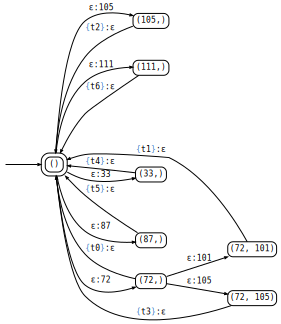

In [8]:
# Build a small BPE FST with readable token labels
bpe_tokens = {
    0: b'H',
    1: b'He',
    2: b'i',
    3: b'Hi',
    4: b'!',
    5: b'W',
    6: b'o',
}

bpe_fst = FST()
bpe_fst.add_start(())
for tok_id, tok_bytes in bpe_tokens.items():
    bx = tuple(tok_bytes)
    for j in range(len(bx)):
        bpe_fst.add_arc(bx[:j], EPSILON, bx[j], bx[:j+1])
    bpe_fst.add_arc(bx, f't{tok_id}', EPSILON, ())
bpe_fst.add_stop(())

display(Markdown('### BPE FST (7 tokens)'))
display(Markdown(
    'Tokens: ' + ', '.join(
        f'`t{i}` = {repr(tok_bytes.decode())}'
        for i, tok_bytes in sorted(bpe_tokens.items())
    )
))
display(visualize_automaton(bpe_fst, coalesce_chains=False))

In [9]:
# Precovers for the BPE FST
# Note: target is in bytes (the output alphabet of the BPE FST)
show_precover(bpe_fst, (), title='BPE, ')
show_precover(bpe_fst, (72,), title='BPE, ')     # 'H'
show_precover(bpe_fst, (72, 105), title='BPE, ')  # 'Hi'

### BPE, target = ''

Standard: **1** states, **7** arcs &nbsp;|&nbsp; Rho-factored: **1** states, **1** arcs (1 ρ) &nbsp;|&nbsp; Equal: ✓

Standard DFA (7 arcs),Rho DFA (1 arcs)
"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- start_{((72,), ()),((), ()),((111,), ()),((105,), ()),((33,), ()),((72, 105), ()),((72, 101), ()),((87,), ())} --> start_{((72,), ()),((), ()),((111,), ()),((105,), ()),((33,), ()),((72, 105), ()),((72, 101), ()),((87,), ())} <!-- 0 --> 0 {((72,), ()),((), ()),((111,), ()),((105,), ()),((33,), ()),((72, 105), ()),((72, 101), ()),((87,), ())} <!-- start_{((72,), ()),((), ()),((111,), ()),((105,), ()),((33,), ()),((72, 105), ()),((72, 101), ()),((87,), ())}->0 --> start_{((72,), ()),((), ()),((111,), ()),((105,), ()),((33,), ()),((72, 105), ()),((72, 101), ()),((87,), ())}->0 <!-- 0->0 --> 0->0 t0 t1 t2 t3 t4 t5 t6","<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- start_frozenset({((72,), ()), ((), ()), ((111,), ()), ((105,), ()), ((33,), ()), ((72, 105), ()), ((72, 101), ()), ((87,), ())}) --> start_frozenset({((72,), ()), ((), ()), ((111,), ()), ((105,), ()), ((33,), ()), ((72, 105), ()), ((72, 101), ()), ((87,), ())}) <!-- 0 --> 0 frozenset({((72,), ()), ((), ()), ((111,), ()), ((105,), ()), ((33,), ()), ((72, 105), ()), ((72, 101), ()), ((87,), ())}) <!-- start_frozenset({((72,), ()), ((), ()), ((111,), ()), ((105,), ()), ((33,), ()), ((72, 105), ()), ((72, 101), ()), ((87,), ())})->0 --> start_frozenset({((72,), ()), ((), ()), ((111,), ()), ((105,), ()), ((33,), ()), ((72, 105), ()), ((72, 101), ()), ((87,), ())})->0 <!-- 0->0 --> 0->0 ρ"


### BPE, target = (72,)

Standard: **2** states, **10** arcs &nbsp;|&nbsp; Rho-factored: **2** states, **4** arcs (1 ρ) &nbsp;|&nbsp; Equal: ✓

Standard DFA (10 arcs),Rho DFA (4 arcs)
"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- start_{((72, 105), (72,)),((72,), (72,)),((72, 101), (72,)),((), ())} --> start_{((72, 105), (72,)),((72,), (72,)),((72, 101), (72,)),((), ())} <!-- 0 --> 0 {((72, 105), (72,)),((72,), (72,)),((72, 101), (72,)),((), ())} <!-- start_{((72, 105), (72,)),((72,), (72,)),((72, 101), (72,)),((), ())}->0 --> start_{((72, 105), (72,)),((72,), (72,)),((72, 101), (72,)),((), ())}->0 <!-- 1 --> 1 {((105,), (72,)),((33,), (72,)),((72, 105), (72,)),((72, 101), (72,)),((87,), (72,)),((72,), (72,)),((), (72,)),((111,), (72,))} <!-- 0->1 --> 0->1 t0 t1 t3 <!-- 1->1 --> 1->1 t0 t1 t2 t3 t4 t5 t6","<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- start_frozenset({((72, 105), (72,)), ((72,), (72,)), ((72, 101), (72,)), ((), ())}) --> start_frozenset({((72, 105), (72,)), ((72,), (72,)), ((72, 101), (72,)), ((), ())}) <!-- 0 --> 0 frozenset({((72, 105), (72,)), ((72,), (72,)), ((72, 101), (72,)), ((), ())}) <!-- start_frozenset({((72, 105), (72,)), ((72,), (72,)), ((72, 101), (72,)), ((), ())})->0 --> start_frozenset({((72, 105), (72,)), ((72,), (72,)), ((72, 101), (72,)), ((), ())})->0 <!-- 1 --> 1 frozenset({((105,), (72,)), ((33,), (72,)), ((72, 105), (72,)), ((72, 101), (72,)), ((87,), (72,)), ((72,), (72,)), ((), (72,)), ((111,), (72,))}) <!-- 0->1 --> 0->1 t0 t1 t3 <!-- 1->1 --> 1->1 ρ"


### BPE, target = (72, 105)

Standard: **3** states, **10** arcs &nbsp;|&nbsp; Rho-factored: **3** states, **4** arcs (1 ρ) &nbsp;|&nbsp; Equal: ✓

Standard DFA (10 arcs),Rho DFA (4 arcs)


## 7. Scaled BPE — seeing the compression ratio

With more tokens, the standard DFA grows linearly in arc count at the boundary,
while the rho-factored DFA stays tiny.

In [10]:
import random
random.seed(42)

def make_bpe_fst(n_tokens):
    """Build a BPE FST with n_tokens synthetic tokens (always includes printable ASCII)."""
    tokens = set()
    # Always include printable ASCII as single-byte tokens
    for b in range(32, 127):
        tokens.add(bytes([b]))
    # Add multi-byte tokens to reach n_tokens
    while len(tokens) < n_tokens:
        n = random.choice([2, 3])
        tokens.add(bytes([random.choice(range(32, 127)) for _ in range(n)]))
    tokens = sorted(tokens)[:n_tokens]
    m = FST()
    m.add_start(())
    for i, tok in enumerate(tokens):
        bx = tuple(tok)
        for j in range(len(bx)):
            m.add_arc(bx[:j], EPSILON, bx[j], bx[:j+1])
        m.add_arc(bx, i, EPSILON, ())
    m.add_stop(())
    return m, tokens

#target = (72, 105)  # 'Hi' in bytes
target = b'Therefor'
rows = []
for n in [95, 150, 300, 500]:
    random.seed(42)
    fst, toks = make_bpe_fst(n)
    alphabet = fst.A - {EPSILON}

    std = LazyDeterminize(PrecoverNFA(fst, target)).materialize()
    std_arcs = sum(1 for s in std.states for _ in std.arcs(s))

    sym = SymbolicLazyDeterminize(PrecoverNFA(fst, target), alphabet)
    rho = sym.materialize()
    rho_arcs = sum(1 for s in rho.states for _ in rho.arcs(s))
    n_rho = sum(1 for s in rho.states for a, _ in rho.arcs(s) if a is RHO)

    eq = std.min().equal(ExpandRho(sym, alphabet).materialize().min())

    rows.append([
        len(toks),
        f'{len(std.states)}',
        f'{std_arcs}',
        f'{len(rho.states)}',
        f'{rho_arcs} ({n_rho} ρ)',
        f'{rho_arcs/std_arcs*100:.1f}%',
        '✓' if eq else '✗',
    ])

display(Markdown(f"### BPE precover DFA size: standard vs rho-factored (target = {target!r})"))
display_table(
    rows,
    headings=['Vocab', 'Std states', 'Std arcs', 'Rho states', 'Rho arcs', 'Ratio', 'Equal'],
)

### BPE precover DFA size: standard vs rho-factored (target = b'Therefor')

Vocab,Std states,Std arcs,Rho states,Rho arcs,Ratio,Equal
95,9,103,9,9 (1 ρ),8.7%,✓
150,9,160,9,11 (1 ρ),6.9%,✓
300,9,310,9,11 (1 ρ),3.5%,✓
500,9,512,9,13 (1 ρ),2.5%,✓


## Summary

The **ρ (rho) arc** factoring is an exact transformation: `L(standard DFA) = L(rho DFA)`.

Key properties:
- **Complete DFA states** (arcs for every alphabet symbol) are factored: the most common
  destination becomes a ρ arc, explicit arcs only for exceptions.
- **Incomplete states** (growing phase, before target is matched) are left unchanged.
- For BPE FSTs, the boundary state has all token arcs going to the same hub, so
  the entire fan-out collapses to **1 ρ arc**.
- DFA state count is `len(target) + 1`, independent of vocabulary size.
- Arc count is **O(target length)** instead of **O(vocab × target length)**.

## 8. Rust-accelerated precover determinization

The Python `LazyDeterminize(PrecoverNFA(...)).materialize()` pipeline is the reference
implementation but doesn't scale beyond ~500 tokens. The Rust backend provides two
fast alternatives:

- **`RustRhoDeterminize`** — rho-factored determinization (same as SymbolicLazyDeterminize but in Rust)
- **`RustDecomp`** — full Q/R decomposition with universality checking

Both scale to 50K+ tokens.

In [11]:
import time
from transduction.rust_bridge import RustRhoDeterminize, RustDecomp, to_rust_fst
from transduction.util import set_memory_limit

set_memory_limit(8)  # safety net (needs headroom for Python det at small vocab)

In [12]:
target = b'Therefor'

# Vocab sizes: Python can handle up to ~500; Rust goes much higher
py_vocab_sizes = [95, 150, 300, 500]
rust_vocab_sizes = [95, 150, 300, 500, 1_000, 2_000, 5_000, 10_000]

rows = []

for n in sorted(set(py_vocab_sizes + rust_vocab_sizes)):
    random.seed(42)
    fst, toks = make_bpe_fst(n)

    row = [len(toks)]

    # --- Python LazyDeterminize (only for small vocab) ---
    if n in py_vocab_sizes:
        t0 = time.perf_counter()
        std = LazyDeterminize(PrecoverNFA(fst, target)).materialize()
        py_ms = (time.perf_counter() - t0) * 1000
        py_states = len(std.states)
        py_arcs = sum(1 for s in std.states for _ in std.arcs(s))
        row += [f'{py_ms:.1f}', f'{py_states}', f'{py_arcs}']
        del std  # free memory
    else:
        row += ['—', '—', '—']

    # --- Rust RustRhoDeterminize ---
    t0 = time.perf_counter()
    rho = RustRhoDeterminize(fst, target)
    rust_rho_ms = (time.perf_counter() - t0) * 1000
    row += [
        f'{rust_rho_ms:.1f}',
        f'{rho.num_states}',
        f'{rho.num_explicit_arcs} + {rho.num_rho_arcs}ρ',
    ]
    del rho

    # --- Rust RustDecomp (full Q/R decomposition) ---
    t0 = time.perf_counter()
    decomp = RustDecomp(fst, target)
    rust_decomp_ms = (time.perf_counter() - t0) * 1000
    q_states = len(decomp.quotient.states)
    q_arcs = sum(1 for s in decomp.quotient.states for _ in decomp.quotient.arcs(s))
    row += [f'{rust_decomp_ms:.1f}', f'{q_states}', f'{q_arcs}']
    del decomp, fst

    # --- Speedup ---
    if n in py_vocab_sizes:
        row.append(f'{py_ms / rust_rho_ms:.0f}x')
    else:
        row.append('—')

    rows.append(row)
    print(f'V={len(toks):>6d}  py={row[1]:>8s}ms  rust_rho={row[4]:>8s}ms  rust_decomp={row[7]:>8s}ms')

display(Markdown(f"### Python vs Rust: precover determinization (target = `{target.decode()}`)\n"))
display_table(
    rows,
    headings=[
        'Vocab',
        'Py ms', 'Py states', 'Py arcs',
        'Rho ms', 'Rho states', 'Rho arcs',
        'Decomp ms', 'Q states', 'Q arcs',
        'Speedup',
    ],
)

V=    95  py=    11.7ms  rust_rho=     2.6ms  rust_decomp=     1.8ms
V=   150  py=    20.2ms  rust_rho=     1.9ms  rust_decomp=     2.6ms
V=   300  py=    52.7ms  rust_rho=     2.2ms  rust_decomp=     7.3ms
V=   500  py=    99.8ms  rust_rho=     6.0ms  rust_decomp=    21.9ms
V=  1000  py=       —ms  rust_rho=    98.9ms  rust_decomp=    77.9ms
V=  2000  py=       —ms  rust_rho=    53.8ms  rust_decomp=   337.8ms
V=  5000  py=       —ms  rust_rho=   205.6ms  rust_decomp=  2018.2ms
V= 10000  py=       —ms  rust_rho=   748.3ms  rust_decomp=  7751.6ms


### Python vs Rust: precover determinization (target = `Therefor`)


Vocab,Py ms,Py states,Py arcs,Rho ms,Rho states,Rho arcs,Decomp ms,Q states,Q arcs,Speedup
95,11.7,9,103,2.6,9,8 + 1ρ,1.8,9,8,4x
150,20.2,9,160,1.9,9,10 + 1ρ,2.6,9,10,10x
300,52.7,9,310,2.2,9,10 + 1ρ,7.3,9,10,24x
500,99.8,9,512,6.0,9,12 + 1ρ,21.9,9,12,17x
1000,—,—,—,98.9,9,19 + 1ρ,77.9,9,19,—
2000,—,—,—,53.8,9,27 + 1ρ,337.8,9,27,—
5000,—,—,—,205.6,9,70 + 1ρ,2018.2,9,70,—
10000,—,—,—,748.3,9,114 + 1ρ,7751.6,9,114,—


### Quick interactive use

Use `RustRhoDeterminize` or `RustDecomp` directly on any FST + target.
The Rust backend handles the full pipeline (FST conversion, NFA construction,
powerset determinization, rho-factoring / universality checking).

In [13]:
# --- RustRhoDeterminize: rho-factored precover DFA ---
random.seed(42)
fst, toks = make_bpe_fst(500)

rho = RustRhoDeterminize(fst, b'Hello')
print(f'RustRhoDeterminize: {rho.num_states} states, '
      f'{rho.num_explicit_arcs} explicit + {rho.num_rho_arcs} rho arcs, '
      f'{rho.total_ms:.2f} ms (Rust-side)')

# Expand rho arcs to get a standard FSA for verification
expanded = rho.expand()
print(f'Expanded: {len(expanded.states)} states, '
      f'{sum(1 for s in expanded.states for _ in expanded.arcs(s))} arcs')

# --- RustDecomp: full Q/R decomposition ---
decomp = RustDecomp(fst, b'Hello')
print(f'\nRustDecomp Q: {len(decomp.quotient.states)} states, '
      f'{sum(1 for s in decomp.quotient.states for _ in decomp.quotient.arcs(s))} arcs')
print(f'RustDecomp R: {len(decomp.remainder.states)} states, '
      f'{sum(1 for s in decomp.remainder.states for _ in decomp.remainder.arcs(s))} arcs')

RustRhoDeterminize: 6 states, 11 explicit + 1 rho arcs, 1.17 ms (Rust-side)
Expanded: 6 states, 511 arcs

RustDecomp Q: 6 states, 11 arcs
RustDecomp R: 6 states, 11 arcs
